In [8]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import numpy as np
from matplotlib import pyplot as plt
from cirq import (
    CXPowGate,
    MixedUnitaryChannel,
    Rx,
    Rz,
    I,
    X,
    Y,
    Z,
    LineQubit,
    Circuit,
    ops,
    unitary,
)
import qiskit
from mitiq import Executor, Observable, PauliString
from mitiq.interface.mitiq_cirq import compute_density_matrix
from mitiq.cdr import generate_training_circuits
from mitiq.cdr._testing import random_x_z_cnot_circuit
from mitiq.pec.representations.learning import (
    biased_noise_loss_function,
    learn_biased_noise_parameters,
)

seed = 1
rng = np.random.RandomState(seed)
circuit = random_x_z_cnot_circuit(
    LineQubit.range(2), n_moments=5, random_state=rng
)


CNOT_ops = list(circuit.findall_operations_with_gate_type(CXPowGate))
Rx_ops = list(circuit.findall_operations_with_gate_type(Rx))
Rz_ops = list(circuit.findall_operations_with_gate_type(Rz))


def ideal_execute(circ: Circuit) -> np.ndarray:
    return compute_density_matrix(circ, noise_level=(0.0,))


ideal_executor = Executor(ideal_execute)
ideal_values = np.array(
    [ideal_executor.evaluate(t, observable) for t in training_circuits]
)


def biased_noise_channel(epsilon: float, eta: float) -> MixedUnitaryChannel:
    a = 1 - epsilon
    b = epsilon * (3 * eta + 1) / (3 * (eta + 1))
    c = epsilon / (3 * (eta + 1))

    mix = [
        (a, unitary(I)),
        (b, unitary(Z)),
        (c, unitary(X)),
        (c, unitary(Y)),
    ]
    return ops.MixedUnitaryChannel(mix)

In [98]:
operations = Rx_ops[0]
epsilon = 0.1
eta = 0
pec_kwargs_learning = {"num_samples": 10000, "random_state": 1}

In [99]:
def noisy_execute(circ: Circuit) -> np.ndarray:
    noisy_circ = circ.copy()[0:0]

    for op in circ.all_operations():
        noisy_circ.append(op)
        if isinstance(op.gate, type(operations[2])):
            qubits = op.qubits
            for q in qubits:
                noisy_circ.append(biased_noise_channel(epsilon, eta)(q))
    return ideal_execute(noisy_circ)

noisy_executor = Executor(noisy_execute)
    
offset = 0.01

if epsilon == 0:
    epsilon0 = 0.1 * offset
else:
    epsilon0 = (1 + offset) * epsilon

if eta == 0:
    eta0 = 0.1 * offset
else:
    eta0 = (1 + offset) * eta

operations_to_learn = [Circuit(operations[1])]

In [100]:
print(epsilon0)
print(eta0)

0.101
0.001


In [71]:
import timeit

start = timeit.default_timer()
# pec_kwargs_learning = {"num_samples": 5000, "random_state": 1}
[epsilon_opt, eta_opt, success] = learn_biased_noise_parameters(
    operations_to_learn=operations_to_learn,
    circuit=circuit,
    ideal_executor=ideal_executor,
    noisy_executor=noisy_executor,
    pec_kwargs=pec_kwargs_learning,
    num_training_circuits=5,
    fraction_non_clifford=0.2,
    epsilon0=epsilon0,
    eta0=eta0,
    observable=observable,
)
end = timeit.default_timer()
print(end - start)
print(success)
print(epsilon_opt)
print(eta_opt)


790.7324035420024
True
0.11103330661173043
1.0100430722736213


In [72]:
print(abs(epsilon_opt-epsilon))
print(abs(epsilon0-epsilon))
print(abs(eta_opt-eta))
print(abs(eta0-eta))

0.061033306611730426
0.0005000000000000004
0.010043072273621334
0.010000000000000009


In [101]:
random_state = np.random.RandomState(1)
training_circuits = generate_training_circuits(
        circuit=circuit,
        num_training_circuits=5,
        fraction_non_clifford=0.2,
        random_state=random_state,
    )
ideal_values = np.array([ideal_executor.evaluate(training_circuit, observable) for training_circuit in training_circuits])

epsilons = np.linspace(0, 0.1, 51)

[0.000669351470706836, 0.0006349070351833701, 0.0006011950505359586, 0.0005682288397955754, 0.000536021949811986, 0.0005045881553646407, 0.0004739414633581745, 0.00044409611710445466, 0.000415066600693008, 0.0007098889483478147, 0.0006741279445250023, 0.0006391022495093599, 0.0006048256622561331, 0.0005713122197571045, 0.0005385762015259054, 0.0005066321341778669, 0.0004754947961067308, 0.0004451792222605271, 0.0001730099504561185, 0.00015398403229297891, 0.00013596825475286774, 0.00011898067398675653, 0.00010303965865198511, 8.816389588837035e-05, 7.43723974228062e-05, 0.000234130961131648, 0.00021193266835303239, 0.00019072172624103845, 0.00017051633788593695, 0.00015133502889761965, 0.00013319665370882208, 0.00011612040201683472, 0.00010012580536699877, 0.0002867072119078123, 0.00026199322815713476, 0.00023825742031207322, 0.00021551841706730896, 0.0001937951859396607, 0.0001731070400564435, 0.0001534736450966474, 0.0001349150263887142, 0.00011745157616889516, 0.00010110406100426841

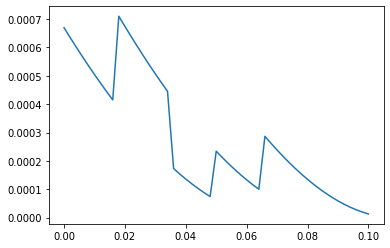

In [102]:
loss_epsilons = [biased_noise_loss_function(
        params=[eps, eta],
        operations_to_mitigate=operations_to_learn,
        training_circuits=training_circuits,
        ideal_values=ideal_values,
        noisy_executor=noisy_executor,
        pec_kwargs=pec_kwargs,
        observable=observable,
    ) for eps in epsilons]
plt.plot(epsilons, loss_epsilons)
print(loss_epsilons)
print([epsilon, eta])

[1.3119295212978301e-05, 2.1940499582639773e-05, 0.00016979162907597764, 0.00017203622689064313, 0.00017453864044819625, 0.00017714392670380462, 0.00017976034648814904, 0.0001823336135857847, 0.00018483219522450825, 0.00018723862787813016, 0.00018954424247709712, 0.00019174588823315974, 0.000193843861588338, 0.00019584057926904508, 0.00019773972003759343, 0.00019954566662668902, 0.00020126314259005123, 0.00020289697712247523, 0.00020445195460834146, 0.00020593272059452175, 0.00020734372544970792, 0.00020868919318682398, 0.00020997310701462596, 0.00021119920590506703, 0.00021237098829108444, 0.00021349172024764753, 0.00021456444635385572, 0.00021559200201340492, 0.00021657702641040964, 0.00021752197555343185, 0.0002184291350516698, 0.00021930063239941297, 0.00022013844863568292, 0.00022094442930861027, 0.00022172029471628367, 4.2996706896370364e-05, 4.3301011962111895e-05, 4.359504568024176e-05, 4.387930091889923e-05, 4.4154241146285236e-05, 4.4420302406771037e-05, 4.467789516536702e-05

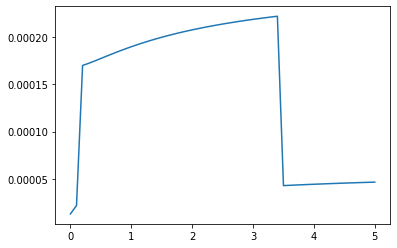

In [104]:
etas = np.linspace(0, 5, 51)
loss_etas = [biased_noise_loss_function(
        params=[epsilon, et],
        operations_to_mitigate=operations_to_learn,
        training_circuits=training_circuits,
        ideal_values=ideal_values,
        noisy_executor=noisy_executor,
        pec_kwargs=pec_kwargs,
        observable=observable,
    ) for et in etas]
plt.plot(etas, loss_etas)
print(loss_etas)
